# block group level regression result

In [4]:
import os
from google.cloud import bigquery
import pandas as pd

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/josie/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

print('Done!')

Done!


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

## import data

In [6]:
data = """
SELECT BlockGroupCode,
       deploymentRate,
       pop / NULLIF(landArea, 0) AS popDensity,
       unemploymentRate,
       houseOwnerRate,
       maleRate,
       ageUnder17Rate,
       ageBetween18and24Rate,
       ageAbove65Rate,
       income AS medianIncome,
       aboveHighSchoolRate,
       aboveBachelorRate,
       whiteRate,
       MovedIn1yearRate,
       newlyMovedRate,
       Latitute,
       Longitude
FROM `broadband-data.capstone.blockgroup_2020`
WHERE SUBSTR(BlockGroupCode, 1, 2) != "02" and SUBSTR(BlockGroupCode, 1, 2) != "15"
"""

data = client.query(data).to_dataframe().dropna()

In [7]:
data.head()

,BlockGroupCode,deploymentRate,popDensity,unemploymentRate,houseOwnerRate,maleRate,ageUnder17Rate,ageBetween18and24Rate,ageAbove65Rate,medianIncome,aboveHighSchoolRate,aboveBachelorRate,whiteRate,MovedIn1yearRate,newlyMovedRate,Latitute,Longitude
0,540779642003,0.475891,25.127852,0.048458,0.860648,0.502935,0.260274,0.048924,0.241683,55707,0.940510,0.152975,0.982387,0.092520,0.046260,39.376724,-79.579149
1,240037401023,0.921751,530.631480,0.000000,0.512433,0.519538,0.130551,0.163410,0.175844,87222,0.831447,0.593711,0.833037,0.095915,0.034636,39.149755,-76.750802
2,310539644001,0.984882,315.650173,0.090837,0.710682,0.519869,0.326650,0.079475,0.123952,53450,0.765500,0.154696,0.935108,0.144349,0.079075,41.428751,-96.542480
3,040130405181,0.543803,13.435978,0.078335,0.847551,0.376414,0.145396,0.011309,0.305331,44615,0.939974,0.184547,0.949919,0.090860,0.055165,33.896291,-112.511262
4,010770115023,0.332420,115.973072,0.023769,0.970097,0.503078,0.239226,0.076517,0.188215,87109,0.991003,0.390746,0.963940,0.080252,0.023445,34.929505,-87.635450


In [8]:
data.columns

Index(['BlockGroupCode', 'deploymentRate', 'popDensity', 'unemploymentRate',
       'houseOwnerRate', 'maleRate', 'ageUnder17Rate', 'ageBetween18and24Rate',
       'ageAbove65Rate', 'medianIncome', 'aboveHighSchoolRate',
       'aboveBachelorRate', 'whiteRate', 'MovedIn1yearRate', 'newlyMovedRate',
       'Latitute', 'Longitude'],
      dtype='object')

### standardization

In [9]:
cols_to_norm = ['deploymentRate', 'popDensity', 'unemploymentRate',
       'houseOwnerRate', 'maleRate', 'ageUnder17Rate', 'ageBetween18and24Rate',
       'ageAbove65Rate', 'medianIncome', 'aboveHighSchoolRate',
       'aboveBachelorRate', 'whiteRate', 'MovedIn1yearRate', 'newlyMovedRate',
       'Latitute', 'Longitude']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.std()))

In [10]:
data_block_group = data.sort_values('deploymentRate',ascending=False)

In [11]:
data_block_group.head()

,BlockGroupCode,deploymentRate,popDensity,unemploymentRate,houseOwnerRate,maleRate,ageUnder17Rate,ageBetween18and24Rate,ageAbove65Rate,medianIncome,aboveHighSchoolRate,aboveBachelorRate,whiteRate,MovedIn1yearRate,newlyMovedRate,Latitute,Longitude
107533,390490093323,0.36326,-0.112579,1.427933,0.803854,-0.066176,-0.198022,-0.908351,1.549513,0.382428,0.760324,-0.694292,-2.768193,0.133661,-0.599935,0.407577,0.534164
133981,090010723003,0.36326,0.185995,0.022388,-0.084426,0.638802,0.215062,0.076117,0.254943,-0.076094,-0.317637,0.217965,-0.741194,0.017705,0.856314,0.666148,1.165877
133972,060855123121,0.36326,0.020350,-0.257743,0.613694,0.044324,0.414765,-0.011988,-0.551550,1.589083,0.572950,0.401232,-0.095150,0.104330,-0.329119,-0.165684,-1.983856
133973,060952518042,0.36326,0.253897,-0.447485,-0.076153,0.189489,-0.543035,0.297307,0.276906,0.92014,0.073327,-0.064829,-2.241645,-0.766620,-0.614209,0.042389,-2.025209
133974,060952519021,0.36326,0.260783,0.140089,-0.601453,1.324773,0.849236,-0.583606,-0.194888,-0.475662,-0.440910,-0.684740,-0.999552,0.305508,-0.139163,0.041814,-2.022950


## correlation

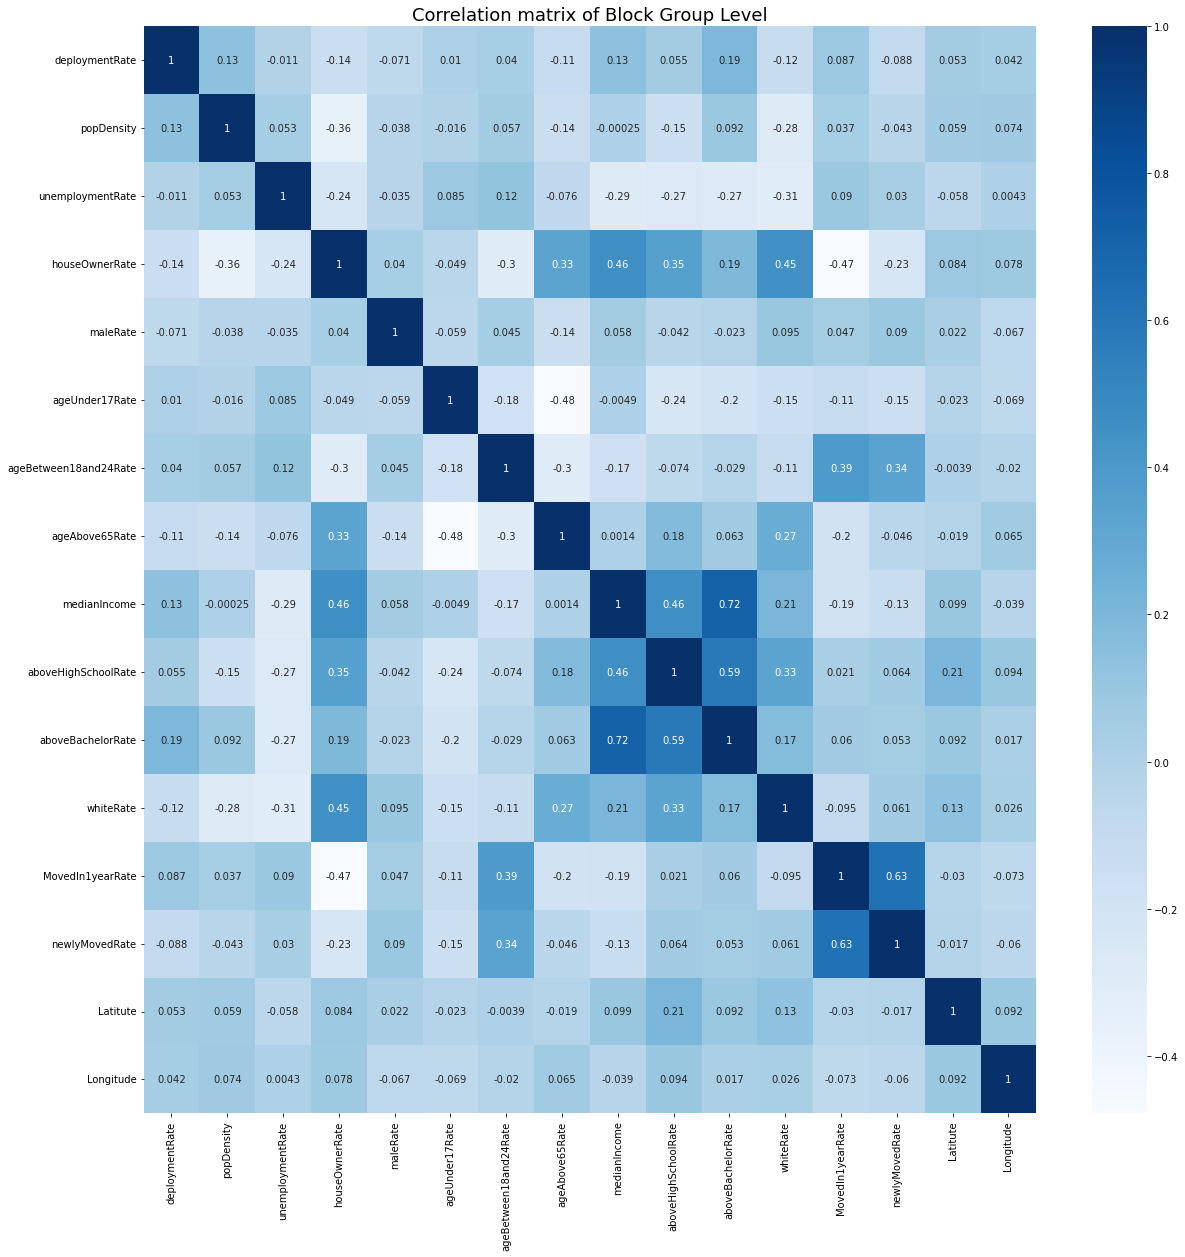

In [12]:
data_block_group2 = data_block_group.drop(['BlockGroupCode'],axis=1)
plt.figure(figsize=(20,20))
sns.heatmap(data_block_group2.corr(),cmap="Blues",annot=True)
plt.title("Correlation matrix of Block Group Level", fontdict = {'fontsize' : 18})
plt.show()

In [15]:
data_block_group2.corr().iloc[0].sort_values(ascending=False)[:16]

deploymentRate           1.000000
aboveBachelorRate        0.191746
popDensity               0.134849
medianIncome             0.134561
MovedIn1yearRate         0.087038
aboveHighSchoolRate      0.055497
Latitute                 0.052863
Longitude                0.041986
ageBetween18and24Rate    0.039758
ageUnder17Rate           0.010178
unemploymentRate        -0.010925
maleRate                -0.071242
newlyMovedRate          -0.088413
ageAbove65Rate          -0.105956
whiteRate               -0.117393
houseOwnerRate          -0.144276
Name: deploymentRate, dtype: float64

### Compared to the county_level result last week, the block_group_level correlation between Population Density and Deployment Rate inceases from 0.042543 to 0.134849, which makes more sense. 

## Regression

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

lr = LinearRegression()
X = data_block_group2.drop(['deploymentRate'],axis=1)
y = data_block_group2['deploymentRate']
lr.fit(X.astype(float),y)

coef = pd.DataFrame({"Feature": X.columns, "Coefficients":lr.coef_})
coef = coef.sort_values("Coefficients",ascending=False)
coef

,Feature,Coefficients
9,aboveBachelorRate,0.139414
11,MovedIn1yearRate,0.137205
7,medianIncome,0.128510
14,Longitude,0.050836
13,Latitute,0.045599
0,popDensity,0.017889
5,ageBetween18and24Rate,0.013325
1,unemploymentRate,-0.005093
4,ageUnder17Rate,-0.007780
8,aboveHighSchoolRate,-0.009182


###  problem solved
last week's popDensity coefficient is negative - makes no sense, now is positive. 
as popDensity inceases, deploymentRate should also incease.

In [17]:
lr = LinearRegression()
X = data_block_group2.drop(['deploymentRate'],axis=1)
y = data_block_group2['deploymentRate']

X_new = sm.add_constant(X)
est = sm.OLS(y, X_new.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         deploymentRate   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     1868.
Date:                Wed, 16 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:03:23   Log-Likelihood:            -2.8237e+05
No. Observations:              208264   AIC:                         5.648e+05
Df Residuals:                  208248   BIC:                         5.649e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.011e-

/Users/josie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### problem solved and new problem
Last week problem: p-value of popDensity is too large (~0.6)
Here, p-value of popDensity<0.001, popDensity is statistically significant now.
However, the R^2 deceases from 0.25 to 0.12 now. This model can barely explain the data.

## Regression one by one

In [20]:
lr = LinearRegression()
X = data_block_group2['popDensity']
y = data_block_group2['deploymentRate']

X_new = sm.add_constant(X)
est = sm.OLS(y, X_new.astype(float))
est2 = est.fit()
print(est2.summary())

/Users/josie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:         deploymentRate   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3857.
Date:                Wed, 16 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:40:21   Log-Likelihood:            -2.9360e+05
No. Observations:              208264   AIC:                         5.872e+05
Df Residuals:                  208262   BIC:                         5.872e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.192e-15      0.002   1.47e-12      1.0

In [21]:
lr = LinearRegression()
X = data_block_group2['aboveBachelorRate']
y = data_block_group2['deploymentRate']

X_new = sm.add_constant(X)
est = sm.OLS(y, X_new.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         deploymentRate   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     7949.
Date:                Wed, 16 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:41:07   Log-Likelihood:            -2.9161e+05
No. Observations:              208264   AIC:                         5.832e+05
Df Residuals:                  208262   BIC:                         5.832e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.082e-15      0.00

/Users/josie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [22]:
lr = LinearRegression()
X = data_block_group2['medianIncome']
y = data_block_group2['deploymentRate']

X_new = sm.add_constant(X)
est = sm.OLS(y, X_new.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         deploymentRate   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3840.
Date:                Wed, 16 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:41:26   Log-Likelihood:            -2.9361e+05
No. Observations:              208264   AIC:                         5.872e+05
Df Residuals:                  208262   BIC:                         5.872e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.192e-15      0.002   1.47e-12   

/Users/josie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [23]:
lr = LinearRegression()
X = data_block_group2['MovedIn1yearRate']
y = data_block_group2['deploymentRate']

X_new = sm.add_constant(X)
est = sm.OLS(y, X_new.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         deploymentRate   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1590.
Date:                Wed, 16 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:41:39   Log-Likelihood:            -2.9472e+05
No. Observations:              208264   AIC:                         5.894e+05
Df Residuals:                  208262   BIC:                         5.895e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.499e-15      0.002  

/Users/josie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
lr = LinearRegression()
X = data_block_group2['houseOwnerRate']
y = data_block_group2['deploymentRate']
X_new = sm.add_constant(X)
est = sm.OLS(y, X_new.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         deploymentRate   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4427.
Date:                Wed, 16 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:44:22   Log-Likelihood:            -2.9332e+05
No. Observations:              208264   AIC:                         5.866e+05
Df Residuals:                  208262   BIC:                         5.867e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.608e-16      0.002  -1.66e

/Users/josie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
lr = LinearRegression()
X = data_block_group2['whiteRate']
y = data_block_group2['deploymentRate']

X_new = sm.add_constant(X)
est = sm.OLS(y, X_new.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         deploymentRate   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2910.
Date:                Wed, 16 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:44:59   Log-Likelihood:            -2.9407e+05
No. Observations:              208264   AIC:                         5.881e+05
Df Residuals:                  208262   BIC:                         5.882e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.746e-15      0.002   2.18e-12      1.0

/Users/josie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
lr = LinearRegression()
X = data_block_group2['ageAbove65Rate']
y = data_block_group2['deploymentRate']

X_new = sm.add_constant(X)
est = sm.OLS(y, X_new.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         deploymentRate   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2365.
Date:                Wed, 16 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:45:21   Log-Likelihood:            -2.9434e+05
No. Observations:              208264   AIC:                         5.887e+05
Df Residuals:                  208262   BIC:                         5.887e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.302e-15      0.002   1.97e

/Users/josie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### results
tried several features that are most correlated to the deploymentRate (both - or +)
coefficients are more significant i.e.(popDensity: 0.1348/0.0179; whiteRate: -0.1179/-0.0523)
however, R^2 is too small (all < 0.05)
Thus, in general, we conclude that OLR is not a good model for the data.